# Final Project

# Comparing Neural Networks for NHL Performance Forecasting

**Group ID: 44**

**Members:<br>
Trevor Lee - 100751771**

The goal here is to use the NHL Player Statistics dataset from Kaggle to compare two different models and see which is more accurate for predicting future performance in the NHL. The dataset contains stats from roughly 1979-1980 to 2019-2020. The selected models will be used to project performance for select players of different ages and positions to project their performance in another season and then the predictions will be compared to the actual results to see which were more accurate. Select players will be chosen to provide an example of the model's accuracy for different players in different situations and career stages.

We will be using the NHL Player Statistics dataset by Benzik on Kaggle (https://www.kaggle.com/datasets/alexbenzik/nhl-players-statistics)

## Preparing the Data

The first thing we need to do is prepare the data so that it is suitable for training.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import torchinfo

import shutil, os, time
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import LightningModule
from lightning.pytorch.callbacks import TQDMProgressBar

import matplotlib.pyplot as plt


Load the data set as a dataframe. The values are serparated by semi-colons instead of commas, so I need to redefine the serparator.

In [2]:
df = pd.read_csv('NHL_Players_Statistics.csv', sep=';')

df.head()

,Name,Date_of_birth,SEASON_year,SEASON,TEAM,Games_Played,Goals,Assists,Points,PlusMinus_Ratings,...,Saves,Save_Percentage,Shutouts,Position,Height,Weight,Body_mass_index,Place_of_birth,Age,Experience
0,Aaron Downey,1974-08-27,2000,'99-'00,BOS,1,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",26,1
1,Aaron Downey,1974-08-27,2001,'00-'01,CHI,3,0.0,0.0,0.0,-1.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",27,2
2,Aaron Downey,1974-08-27,2002,'01-'02,CHI,36,1.0,0.0,1.0,-2.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",28,3
3,Aaron Downey,1974-08-27,2003,'02-'03,DAL,43,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",29,4
4,Aaron Downey,1974-08-27,2004,'03-'04,DAL,37,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,Right_wing,185,98,28.6,"Shelburne, Ontario",30,5


Now let's take a look at properties of the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27319 entries, 0 to 27318
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   27319 non-null  object 
 1   Date_of_birth          27319 non-null  object 
 2   SEASON_year            27319 non-null  int64  
 3   SEASON                 27319 non-null  object 
 4   TEAM                   27319 non-null  object 
 5   Games_Played           27319 non-null  int64  
 6   Goals                  24802 non-null  float64
 7   Assists                24802 non-null  float64
 8   Points                 24802 non-null  float64
 9   PlusMinus_Ratings      24802 non-null  float64
 10  Penalty_Minutes        24802 non-null  float64
 11  Shots_on_Goal          24802 non-null  float64
 12  Shooting_Percentage    24802 non-null  float64
 13  PowerPlay_Goals        24802 non-null  float64
 14  PowerPlay_Assists      24802 non-null  float64
 15  Sh

The first thing we need to trim from the dataset is players with the position of `'Goaltender'`. These players have their stats recorded differently than skaters do and can cause issues.

In [4]:
df = df[df['Position'] != 'Goaltender'].copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24802 entries, 0 to 27318
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   24802 non-null  object 
 1   Date_of_birth          24802 non-null  object 
 2   SEASON_year            24802 non-null  int64  
 3   SEASON                 24802 non-null  object 
 4   TEAM                   24802 non-null  object 
 5   Games_Played           24802 non-null  int64  
 6   Goals                  24802 non-null  float64
 7   Assists                24802 non-null  float64
 8   Points                 24802 non-null  float64
 9   PlusMinus_Ratings      24802 non-null  float64
 10  Penalty_Minutes        24802 non-null  float64
 11  Shots_on_Goal          24802 non-null  float64
 12  Shooting_Percentage    24802 non-null  float64
 13  PowerPlay_Goals        24802 non-null  float64
 14  PowerPlay_Assists      24802 non-null  float64
 15  Short_G

The reduced number of entries and the goalie stats all having a count of 0 confirms that the correct players were removed.

Next we want to only keep the relevant columns or ones that could be relevant rather than keep all 40 columns.

In [5]:
cols = [
    'Name',
    'Date_of_birth',    # needed to differentiate players with the same name playing in the same year
    'SEASON_year',
    'Games_Played',
    'Goals',
    'Assists',
    'Points',
    'Shots_on_Goal',
    'Shooting_Percentage',
    'PowerPlay_Goals',
    'PowerPlay_Assists',
    'Short_Goals',
    'Short_Assists',
    'Position',
    'Height',
    'Weight',
    'Body_mass_index',
    'Age',
    'Experience',
]

df = df[cols].copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24802 entries, 0 to 27318
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 24802 non-null  object 
 1   Date_of_birth        24802 non-null  object 
 2   SEASON_year          24802 non-null  int64  
 3   Games_Played         24802 non-null  int64  
 4   Goals                24802 non-null  float64
 5   Assists              24802 non-null  float64
 6   Points               24802 non-null  float64
 7   Shots_on_Goal        24802 non-null  float64
 8   Shooting_Percentage  24802 non-null  float64
 9   PowerPlay_Goals      24802 non-null  float64
 10  PowerPlay_Assists    24802 non-null  float64
 11  Short_Goals          24802 non-null  float64
 12  Short_Assists        24802 non-null  float64
 13  Position             24802 non-null  object 
 14  Height               24802 non-null  int64  
 15  Weight               24802 non-null  int6

In [6]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,Shooting_Percentage,PowerPlay_Goals,PowerPlay_Assists,Short_Goals,Short_Assists,Position,Height,Weight,Body_mass_index,Age,Experience
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,26,1
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,27,2
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,10.0,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,28,3
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,7.1,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,29,4
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,9.1,0.0,0.0,0.0,0.0,Right_wing,185,98,28.6,30,5


Here's an issue I noticed with the `'Position'` data:

In [7]:
df["Position"].unique()

array(['Right_wing', 'Centre', 'Defence', 'Left_wing', 'Forward'],
      dtype=object)

Most of the categorization is fine. However, having `'Forward'` as a category is a bit of an issue. We don't know which of the forward positions to apply to the player. While it might only affect a few players, it does complicate the data. As such, we'll map forward to 0 and defence to 1.

In [8]:
df['Position'] = np.where(
    df['Position'].str.contains('Defen', case=False, na=False),
    1,  # Defence
    0,  # Forward
)

Next we need to handle instances where the player swaps teams for whatever reason (i.e. trade, waivers) within a given season. This will be done by aggregating their stats.

In [9]:
# These are the columns used to identify a player
id_cols = [
    'Name',
    'Date_of_birth',
    'SEASON_year',
]

# These are the stats to be summed within a season if there are multiple entries
# for a player
sum_cols = [
    'Games_Played',
    'Goals',
    'Assists',
    'Points',
    'Shots_on_Goal',
    'PowerPlay_Goals',
    'PowerPlay_Assists',
    'Short_Goals',
    'Short_Assists',
]

# These are the other columns with data we want to keep and should theoretically
# be the same within the given season
other_cols =[
    'Position',
    'Height',
    'Weight',
    'Body_mass_index',
    'Age',
    'Experience',
]

# Here we define how the data will be aggregated
agg_dict = {col: 'sum' for col in sum_cols}
agg_dict.update({col: 'first' for col in other_cols})

df = df.groupby(id_cols, as_index=False).agg(agg_dict)

# We also need to recompute shooting percentage
# This will also be marginally more accurate since the dataset only has one
# decimal point
df['Shooting_Percentage'] = np.where(
    df['Shots_on_Goal'] > 0,                    # with zero div protection
    df['Goals'] / df['Shots_on_Goal'] * 100,
    0.0
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22465 entries, 0 to 22464
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 22465 non-null  object 
 1   Date_of_birth        22465 non-null  object 
 2   SEASON_year          22465 non-null  int64  
 3   Games_Played         22465 non-null  int64  
 4   Goals                22465 non-null  float64
 5   Assists              22465 non-null  float64
 6   Points               22465 non-null  float64
 7   Shots_on_Goal        22465 non-null  float64
 8   PowerPlay_Goals      22465 non-null  float64
 9   PowerPlay_Assists    22465 non-null  float64
 10  Short_Goals          22465 non-null  float64
 11  Short_Assists        22465 non-null  float64
 12  Position             22465 non-null  int64  
 13  Height               22465 non-null  int64  
 14  Weight               22465 non-null  int64  
 15  Body_mass_index      22465 non-null 

In [10]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,Short_Goals,Short_Assists,Position,Height,Weight,Body_mass_index,Age,Experience,Shooting_Percentage
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,185,98,28.6,26,1,0.000000
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,185,98,28.6,27,2,0.000000
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,0.0,0.0,0,185,98,28.6,28,3,10.000000
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,0.0,0.0,0,185,98,28.6,29,4,7.142857
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,0.0,0.0,0,185,98,28.6,30,5,9.090909


Now we need to create "per game" versions for our major stats. These will help our model retain its accuracy in cases where a player had a injury-riddled season.

In [11]:
df['G_per_gp'] = df['Goals'] / df['Games_Played']
df['A_per_gp'] = df['Assists'] / df['Games_Played']
df['SOG_per_gp'] = df['Shots_on_Goal'] / df['Games_Played']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22465 entries, 0 to 22464
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 22465 non-null  object 
 1   Date_of_birth        22465 non-null  object 
 2   SEASON_year          22465 non-null  int64  
 3   Games_Played         22465 non-null  int64  
 4   Goals                22465 non-null  float64
 5   Assists              22465 non-null  float64
 6   Points               22465 non-null  float64
 7   Shots_on_Goal        22465 non-null  float64
 8   PowerPlay_Goals      22465 non-null  float64
 9   PowerPlay_Assists    22465 non-null  float64
 10  Short_Goals          22465 non-null  float64
 11  Short_Assists        22465 non-null  float64
 12  Position             22465 non-null  int64  
 13  Height               22465 non-null  int64  
 14  Weight               22465 non-null  int64  
 15  Body_mass_index      22465 non-null 

In [12]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,Position,Height,Weight,Body_mass_index,Age,Experience,Shooting_Percentage,G_per_gp,A_per_gp,SOG_per_gp
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0,185,98,28.6,26,1,0.000000,0.000000,0.000000,0.000000
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,...,0,185,98,28.6,27,2,0.000000,0.000000,0.000000,0.666667
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,0,185,98,28.6,28,3,10.000000,0.027778,0.000000,0.277778
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,0,185,98,28.6,29,4,7.142857,0.023256,0.023256,0.325581
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,0,185,98,28.6,30,5,9.090909,0.027027,0.027027,0.297297


Now we have a polished version of single season stats. However, we need to pair it with the next season's stats as prediction targets.

In [13]:
# It should already be the case, but sort the data again just in case
df = df.sort_values(['Name', 'Date_of_birth', 'SEASON_year'])

# Group by player
grouped = df.groupby(['Name', 'Date_of_birth'])

# Append the players' next season stats
df['SEASON_year_next'] = grouped['SEASON_year'].shift(-1)
df['Games_Played_next'] = grouped['Games_Played'].shift(-1)
df['Goals_next'] = grouped['Goals'].shift(-1)
df['Assists_next'] = grouped['Assists'].shift(-1)
df['Points_next'] = grouped['Points'].shift(-1)
df['Shots_on_Goal_next'] = grouped['Shots_on_Goal'].shift(-1)
df['G_per_gp_next'] = grouped['G_per_gp'].shift(-1)
df['A_per_gp_next'] = grouped['A_per_gp'].shift(-1)
df['SOG_per_gp_next'] = grouped['SOG_per_gp'].shift(-1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22465 entries, 0 to 22464
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 22465 non-null  object 
 1   Date_of_birth        22465 non-null  object 
 2   SEASON_year          22465 non-null  int64  
 3   Games_Played         22465 non-null  int64  
 4   Goals                22465 non-null  float64
 5   Assists              22465 non-null  float64
 6   Points               22465 non-null  float64
 7   Shots_on_Goal        22465 non-null  float64
 8   PowerPlay_Goals      22465 non-null  float64
 9   PowerPlay_Assists    22465 non-null  float64
 10  Short_Goals          22465 non-null  float64
 11  Short_Assists        22465 non-null  float64
 12  Position             22465 non-null  int64  
 13  Height               22465 non-null  int64  
 14  Weight               22465 non-null  int64  
 15  Body_mass_index      22465 non-null 

In [14]:
df.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,SOG_per_gp,SEASON_year_next,Games_Played_next,Goals_next,Assists_next,Points_next,Shots_on_Goal_next,G_per_gp_next,A_per_gp_next,SOG_per_gp_next
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2001.0,3.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.666667
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,...,0.666667,2002.0,36.0,1.0,0.0,1.0,10.0,0.027778,0.000000,0.277778
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,0.277778,2003.0,43.0,1.0,1.0,2.0,14.0,0.023256,0.023256,0.325581
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,0.325581,2004.0,37.0,1.0,1.0,2.0,11.0,0.027027,0.027027,0.297297
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,0.297297,2006.0,42.0,3.0,4.0,7.0,21.0,0.071429,0.095238,0.500000


Now we need to make sure that each set of data we just manipulated actually has a next season attached to it and that the player didn't end their playing career.

In [15]:
mask_has_next = df['Games_Played_next'].notna()

# New dataset with only players that have a next season
df_3yr = df[mask_has_next].copy()

df_3yr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19460 entries, 0 to 22463
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 19460 non-null  object 
 1   Date_of_birth        19460 non-null  object 
 2   SEASON_year          19460 non-null  int64  
 3   Games_Played         19460 non-null  int64  
 4   Goals                19460 non-null  float64
 5   Assists              19460 non-null  float64
 6   Points               19460 non-null  float64
 7   Shots_on_Goal        19460 non-null  float64
 8   PowerPlay_Goals      19460 non-null  float64
 9   PowerPlay_Assists    19460 non-null  float64
 10  Short_Goals          19460 non-null  float64
 11  Short_Assists        19460 non-null  float64
 12  Position             19460 non-null  int64  
 13  Height               19460 non-null  int64  
 14  Weight               19460 non-null  int64  
 15  Body_mass_index      19460 non-null  floa

In [16]:
df_3yr.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,SOG_per_gp,SEASON_year_next,Games_Played_next,Goals_next,Assists_next,Points_next,Shots_on_Goal_next,G_per_gp_next,A_per_gp_next,SOG_per_gp_next
0,Aaron Downey,1974-08-27,2000,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2001.0,3.0,0.0,0.0,0.0,2.0,0.000000,0.000000,0.666667
1,Aaron Downey,1974-08-27,2001,3,0.0,0.0,0.0,2.0,0.0,0.0,...,0.666667,2002.0,36.0,1.0,0.0,1.0,10.0,0.027778,0.000000,0.277778
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,0.277778,2003.0,43.0,1.0,1.0,2.0,14.0,0.023256,0.023256,0.325581
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,0.325581,2004.0,37.0,1.0,1.0,2.0,11.0,0.027027,0.027027,0.297297
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,0.297297,2006.0,42.0,3.0,4.0,7.0,21.0,0.071429,0.095238,0.500000


A new dataset was made so that we can keep the old one for a data reference while still having the new dataset to train with.

Using one season can lead to muddled results. It isn't uncommon in sports for players to just have an off year. So we will be capturing three seasons of history. To do this, we will attach the previous two season rates to the data.

In [17]:
# Previous season per game stats and Games played
df_3yr['G_per_gp_prev'] = grouped['G_per_gp'].shift(1)
df_3yr['A_per_gp_prev'] = grouped['A_per_gp'].shift(1)
df_3yr['SOG_per_gp_prev'] = grouped['SOG_per_gp'].shift(1)
df_3yr['Games_played_prev'] = grouped['Games_Played'].shift(1)
df_3yr['Shooting_Percentage_prev'] = grouped['Shooting_Percentage'].shift(1)

# Same but two seasons ago
df_3yr['G_per_gp_prev2'] = grouped['G_per_gp'].shift(2)
df_3yr['A_per_gp_prev2'] = grouped['A_per_gp'].shift(2)
df_3yr['SOG_per_gp_prev2'] = grouped['SOG_per_gp'].shift(2)
df_3yr['Games_played_prev2'] = grouped['Games_Played'].shift(2)
df_3yr['Shooting_Percentage_prev2'] = grouped['Shooting_Percentage'].shift(2)

In [18]:
# Mask to ensure we have data for the previous two seasons
mask_has_prev2 = df_3yr['Games_played_prev2'].notna()

df_3yr = df_3yr[mask_has_prev2].copy()

df_3yr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14514 entries, 2 to 22463
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       14514 non-null  object 
 1   Date_of_birth              14514 non-null  object 
 2   SEASON_year                14514 non-null  int64  
 3   Games_Played               14514 non-null  int64  
 4   Goals                      14514 non-null  float64
 5   Assists                    14514 non-null  float64
 6   Points                     14514 non-null  float64
 7   Shots_on_Goal              14514 non-null  float64
 8   PowerPlay_Goals            14514 non-null  float64
 9   PowerPlay_Assists          14514 non-null  float64
 10  Short_Goals                14514 non-null  float64
 11  Short_Assists              14514 non-null  float64
 12  Position                   14514 non-null  int64  
 13  Height                     14514 non-null  int64  


In [19]:
df_3yr.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,G_per_gp_prev,A_per_gp_prev,SOG_per_gp_prev,Games_played_prev,Shooting_Percentage_prev,G_per_gp_prev2,A_per_gp_prev2,SOG_per_gp_prev2,Games_played_prev2,Shooting_Percentage_prev2
2,Aaron Downey,1974-08-27,2002,36,1.0,0.0,1.0,10.0,0.0,0.0,...,0.000000,0.000000,0.666667,3.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
3,Aaron Downey,1974-08-27,2003,43,1.0,1.0,2.0,14.0,0.0,0.0,...,0.027778,0.000000,0.277778,36.0,10.000000,0.000000,0.000000,0.666667,3.0,0.000000
4,Aaron Downey,1974-08-27,2004,37,1.0,1.0,2.0,11.0,0.0,0.0,...,0.023256,0.023256,0.325581,43.0,7.142857,0.027778,0.000000,0.277778,36.0,10.000000
5,Aaron Downey,1974-08-27,2006,42,3.0,4.0,7.0,21.0,0.0,0.0,...,0.027027,0.027027,0.297297,37.0,9.090909,0.023256,0.023256,0.325581,43.0,7.142857
6,Aaron Downey,1974-08-27,2007,21,1.0,0.0,1.0,10.0,0.0,0.0,...,0.071429,0.095238,0.500000,42.0,14.285714,0.027027,0.027027,0.297297,37.0,9.090909


Now we have to establish our targets and features.

First, the targets...

In [20]:
targets = [
    'G_per_gp_next',
    'A_per_gp_next',
    'SOG_per_gp_next',
    'Games_Played_next',
]

and now the inputs...

In [21]:
inputs = [
    'G_per_gp_prev2',
    'A_per_gp_prev2',
    'SOG_per_gp_prev2',
    'Games_played_prev2',
    'Shooting_Percentage_prev2',
    'G_per_gp_prev',
    'A_per_gp_prev',
    'SOG_per_gp_prev',
    'Games_played_prev',
    'Shooting_Percentage_prev',
    'G_per_gp',
    'A_per_gp',
    'SOG_per_gp',
    'Shooting_Percentage',
    'Games_Played',
    'Position',
    'Age',
    'Experience',
    'Height',
    'Weight',
    'Body_mass_index',
]

Now we just set those targets and features as `'x'` and `'y'`.

In [22]:
x = df_3yr[inputs].values.astype(np.float32)
y = df_3yr[targets].values.astype(np.float32)


And then we'll turn them into tensors.

In [23]:
x = torch.tensor(x)
y = torch.tensor(y)

Global helpers:

In [24]:
num_inputs = x.shape[1]
num_targets = y.shape[1]

epochs = 100

Now to build our datasets.

In [25]:
dataset = TensorDataset(x, y)

# Split into training and validation datasets
torch.manual_seed(0)
(train_dataset, val_dataset) = torch.utils.data.random_split(dataset, [0.7, 0.3])

len(train_dataset), len(val_dataset)

(10160, 4354)

And DataLoaders.

In [26]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Helper Functions

A lot of these functions are imported from past assignments.

The below cell is code from assignment 2 with slight modification

In [27]:
#
# This function describes the architecture of the model
# in terms of its layers, as well as computing
# the total number of parameters the model uses.
#
def describe(model, **kwargs):
    return torchinfo.summary(
        model,
        input_size=(batch_size, num_inputs),
        col_names=['input_size', 'output_size', 'num_params'],
        row_settings=['ascii_only'],
    )

This is a merge of the train functions from assignments 2 and 3.

I'm running this in VSCode on my own PC, so I added a working progressbar that will display within that environment.

In [28]:
#
# This function performs training using Lightning trainer.
# It saves the model checkpoint under ./logs/.../version_0
# The logged metrics will also be saved here.
#
def train(*, name, model:LightningModule, epochs: int=5):
    # This makes the lines on the comparison graph identical
    # with different magnitudes depending on model
    seed_everything(0, workers=True)

    # Clean previous logs
    shutil.rmtree(f'./logs/{name}', ignore_errors=True)

    # Set up lightning trainer and logger
    logger = CSVLogger('./logs', name=name)

    progress_bar = TQDMProgressBar(refresh_rate=1)

    trainer = Trainer(
        max_epochs=epochs,
        logger=logger,
        callbacks=[progress_bar],
        enable_progress_bar=True,
    )

    # Training
    start = time.time()
    trainer.fit(model, train_dataloader, val_dataloader)
    duration = time.time() - start
    print(f"Training time: {duration:.2f} seconds")
    print(trainer.validate(model, val_dataloader))

This is a version of MyLightning from assignment 3, a partial lightning module

I have modified it to fit the purposes for this project. One such change is changing how accuracy is recorded. We aren't using inidividual classes but instead are predicting floating point values. Instead of right or wrong, we will check the error between to actual and calculated values.

In [29]:
class MyLightning(LightningModule):
    def training_step(self, batch):
        x, target = batch
        y = self.forward(x)
        loss = nn.MSELoss()(y, target)
        err = torch.mean(torch.abs(y - target))
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_err', err, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, target = batch
        y = self.forward(x)
        error = torch.mean(torch.abs(y - target))
        self.log('val_err', error, prog_bar=True)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

I've modified the below code from assignment 2. It functions the same, but instead will take a list of the model names and output them onto the same graph. This will be useful for comparing later. I've made it optional to hide `'train_err'` here because it makes the graphs harder to read when comparing and `'val_err'` shows the actual predictions. I've also added the freedom to tighten the scale so initially large errors don't wreck it.

In [30]:
def show_metrics(names, lower=3.0, upper=5.25, show_train=True):
    # This line is to allow name to be either a single string or a list
    if isinstance(names, str):
        names = [names]

    ax = None

    for name in names:
        df = pd.read_csv(f'./logs/{name}/version_0/metrics.csv')
        df.set_index('step', inplace=True)
        if ax is None:
            ax = df['val_err'].dropna().plot(label=f'{name}_val_err')
        else:
            df['val_err'].dropna().plot(ax=ax, label=f'{name}_val_err')
        if show_train:
            df['train_err'].dropna().plot(ax=ax, label=f'{name}_train_err')

    ax.legend()

    # The first few values can be pretty large and pull the scale up. 
    # We want it tighter so we can actually see what's happening
    ax.set_ylim(lower, upper)

## MLP

Here we will define our MLP classifier.

In [31]:
class MLP(MyLightning):
    def __init__(self, hidden):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(num_inputs, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_targets)
        )
    
    def forward(self, x):
        return self.nn(x)

Next we will train it.

In [32]:
mlp = MLP(hidden=64)
describe(mlp)

Layer (type)                             Input Shape               Output Shape              Param #
MLP                                      [128, 21]                 [128, 4]                  --
+ Sequential                             [128, 21]                 [128, 4]                  --
|    + Linear                            [128, 21]                 [128, 64]                 1,408
|    + ReLU                              [128, 64]                 [128, 64]                 --
|    + Linear                            [128, 64]                 [128, 4]                  260
Total params: 1,668
Trainable params: 1,668
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.21
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.01
Estimated Total Size (MB): 0.09

In [33]:
train(name='MLP', model=mlp, epochs=epochs)

Seed set to 0
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ nn   │ Sequential │  1.7 K │ train │     0 │
└───┴──────┴────────────┴────────┴───────┴───────┘

Trainable params: 1.7 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 4                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 193.64it/s, v_num=0, train_loss=86.20, train_err=3.910, val_err=4.040]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 184.34it/s, v_num=0, train_loss=86.20, train_err=3.910, val_err=4.040]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training time: 43.51 seconds
Validation DataLoader 0: 100%|██████████| 35/35 [00:00<00:00, 582.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_err          │     4.036357879638672     │
└───────────────────────────┴───────────────────────────┘

[{'val_err': 4.036357879638672}]


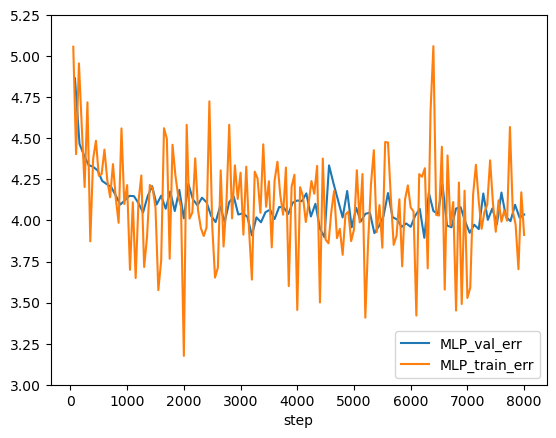

In [34]:
show_metrics('MLP')

## RNN

Now we will define our RNN classifier in advance of LSTM.

The forward pass function will need to act a little differently than it did in the third assignment. Our data is currently in the form of a vector of continuous stats. We need to shape them back into 3 season lines.

Just as a small refresher...

In [35]:
inputs

['G_per_gp_prev2',
 'A_per_gp_prev2',
 'SOG_per_gp_prev2',
 'Games_played_prev2',
 'Shooting_Percentage_prev2',
 'G_per_gp_prev',
 'A_per_gp_prev',
 'SOG_per_gp_prev',
 'Games_played_prev',
 'Shooting_Percentage_prev',
 'G_per_gp',
 'A_per_gp',
 'SOG_per_gp',
 'Shooting_Percentage',
 'Games_Played',
 'Position',
 'Age',
 'Experience',
 'Height',
 'Weight',
 'Body_mass_index']

In [36]:
class RNN(MyLightning):
    def __init__(self, hidden):
        super().__init__()

        # additonal variables to handle seasons smoothly
        self.num_seasons = 3
        self.total_stats = self.num_seasons * num_targets
        self.num_other = num_inputs - self.total_stats

        self.rnn = nn.RNN(
            num_targets,
            hidden,
            num_layers=1,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden + self.num_other, num_targets)

    def forward(self, x):
        #
        # We need to reshape the embeddings because RNN expects a 3D tensor.
        # So we will reshape them into normal season stats
        #
        batch_size = x.size(0)

        stats = x[:, :self.total_stats]         # the first features are the counting
                                                # stats with respect to seasons.
        other = x[:, self.total_stats:]         # these are the other features

        seasons = stats.view(batch_size, self.num_seasons, num_targets)

        out, _ = self.rnn(seasons)
        out = out[:, -1, :]
        out = torch.cat([out, other], dim=1)    # added line to concatenate the
                                                # other features back to the output
        out = self.fc(out)
        return out

Now to train it.

In [37]:
rnn = RNN(hidden=64)
describe(rnn)

Layer (type)                             Input Shape               Output Shape              Param #
RNN                                      [128, 21]                 [128, 4]                  --
+ RNN                                    [128, 3, 4]               [128, 3, 64]              4,480
+ Linear                                 [128, 73]                 [128, 4]                  296
Total params: 4,776
Trainable params: 4,776
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.76
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.02
Estimated Total Size (MB): 0.23

In [38]:
train(name='RNN', model=rnn, epochs=epochs)

Seed set to 0
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ rnn  │ RNN    │  4.5 K │ train │     0 │
│ 1 │ fc   │ Linear │    296 │ train │     0 │
└───┴──────┴────────┴────────┴───────┴───────┘

Trainable params: 4.8 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.8 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 156.29it/s, v_num=0, train_loss=95.50, train_err=4.100, val_err=4.070]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 149.93it/s, v_num=0, train_loss=95.50, train_err=4.100, val_err=4.070]
Training time: 49.19 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 35/35 [00:00<00:00, 511.24it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_err          │     4.070187568664551     │
└───────────────────────────┴───────────────────────────┘

[{'val_err': 4.070187568664551}]


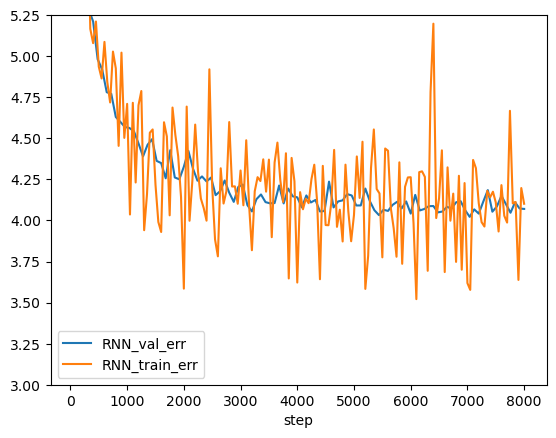

In [39]:
show_metrics('RNN')

## LSTM

Lastly, we define the LSTM classifier. This will largely be the same as the RNN classifier, but with LSTM instead.

In [40]:
class LSTM(MyLightning):
    def __init__(self, hidden):
        super().__init__()

        # additonal variables to handle seasons smoothly
        self.num_seasons = 3
        self.total_stats = self.num_seasons * num_targets
        self.num_other = num_inputs - self.total_stats

        self.lstm = nn.LSTM(
            num_targets,
            hidden,
            num_layers=1,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden + self.num_other, num_targets)

    def forward(self, x):
        #
        # We need to reshape the embeddings because RNN expects a 3D tensor.
        # So we will reshape them into normal season stats
        #
        batch_size = x.size(0)

        stats = x[:, :self.total_stats]         # the first features are the counting
                                                # stats with respect to seasons.
        other = x[:, self.total_stats:]         # these are the other features

        seasons = stats.view(batch_size, self.num_seasons, num_targets)

        out, _ = self.lstm(seasons)
        out = out[:, -1, :]
        out = torch.cat([out, other], dim=1)    # added line to concatenate the
                                                # other features back to the output
        out = self.fc(out)
        return out

And then train the model.

In [41]:
lstm = LSTM(hidden=64)
describe(lstm)

Layer (type)                             Input Shape               Output Shape              Param #
LSTM                                     [128, 21]                 [128, 4]                  --
+ LSTM                                   [128, 3, 4]               [128, 3, 64]              17,920
+ Linear                                 [128, 73]                 [128, 4]                  296
Total params: 18,216
Trainable params: 18,216
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.92
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.07
Estimated Total Size (MB): 0.28

In [42]:
train(name='LSTM', model=lstm, epochs=epochs)

Seed set to 0
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm │ LSTM   │ 17.9 K │ train │     0 │
│ 1 │ fc   │ Linear │    296 │ train │     0 │
└───┴──────┴────────┴────────┴───────┴───────┘

Trainable params: 18.2 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 18.2 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 161.54it/s, v_num=0, train_loss=95.50, train_err=4.090, val_err=4.060]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 154.27it/s, v_num=0, train_loss=95.50, train_err=4.090, val_err=4.060]
Training time: 50.31 seconds


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 35/35 [00:00<00:00, 481.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_err          │     4.056393146514893     │
└───────────────────────────┴───────────────────────────┘

[{'val_err': 4.056393146514893}]


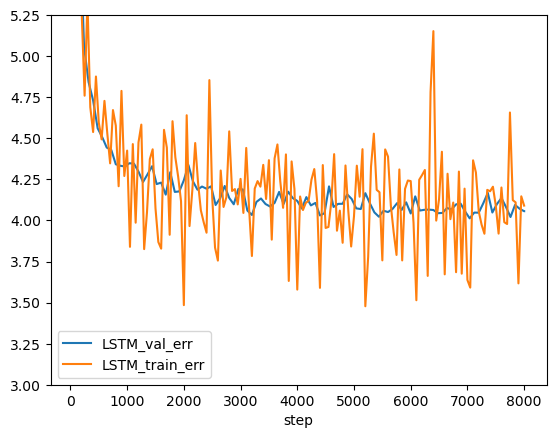

In [43]:
show_metrics('LSTM')

## LSTM with MLP instead of Linear

For comparison's sake, we'll replace the Linear function in LSTM with an MLP sequence.

In [44]:
class LSTM_MLP(MyLightning):
    def __init__(self, hidden):
        super().__init__()

        # additonal variables to handle seasons smoothly
        self.num_seasons = 3
        self.total_stats = self.num_seasons * num_targets
        self.num_other = num_inputs - self.total_stats

        self.lstm = nn.LSTM(
            num_targets,
            hidden,
            num_layers=1,
            batch_first=True,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden + self.num_other, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_targets)
        )

    def forward(self, x):
        #
        # We need to reshape the embeddings because RNN expects a 3D tensor.
        # So we will reshape them into normal season stats
        #
        batch_size = x.size(0)

        stats = x[:, :self.total_stats]         # the first features are the counting
                                                # stats with respect to seasons.
        other = x[:, self.total_stats:]         # these are the other features

        seasons = stats.view(batch_size, self.num_seasons, num_targets)

        out, _ = self.lstm(seasons)
        out = out[:, -1, :]
        out = torch.cat([out, other], dim=1)    # added line to concatenate the
                                                # other features back to the output
        out = self.fc(out)
        return out

In [45]:
lstm_mlp = LSTM_MLP(hidden=64)
describe(lstm_mlp)

Layer (type)                             Input Shape               Output Shape              Param #
LSTM_MLP                                 [128, 21]                 [128, 4]                  --
+ LSTM                                   [128, 3, 4]               [128, 3, 64]              17,920
+ Sequential                             [128, 73]                 [128, 4]                  --
|    + Linear                            [128, 73]                 [128, 64]                 4,736
|    + ReLU                              [128, 64]                 [128, 64]                 --
|    + Linear                            [128, 64]                 [128, 4]                  260
Total params: 22,916
Trainable params: 22,916
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.52
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.09
Estimated Total Size (MB): 0.37

In [46]:
train(name='LSTM_MLP', model=lstm_mlp, epochs=epochs)

Seed set to 0
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ lstm │ LSTM       │ 17.9 K │ train │     0 │
│ 1 │ fc   │ Sequential │  5.0 K │ train │     0 │
└───┴──────┴────────────┴────────┴───────┴───────┘

Trainable params: 22.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.9 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 159.68it/s, v_num=0, train_loss=89.80, train_err=3.980, val_err=4.050]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 80/80 [00:00<00:00, 152.40it/s, v_num=0, train_loss=89.80, train_err=3.980, val_err=4.050]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training time: 54.26 seconds
Validation DataLoader 0: 100%|██████████| 35/35 [00:00<00:00, 478.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_err          │     4.050400733947754     │
└───────────────────────────┴───────────────────────────┘

[{'val_err': 4.050400733947754}]


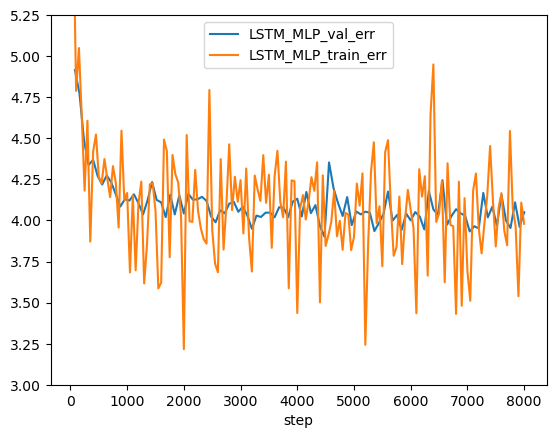

In [47]:
show_metrics('LSTM_MLP')

## Comparing Performance

Here we will compare how the models did relative to each other. First, we will overlay the graph onto each other so we have a visual representation. We're hiding the training error because than makes the graphs significantly harder to read.

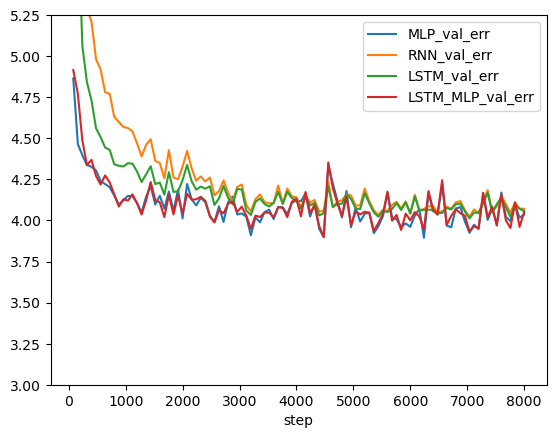

In [48]:
show_metrics(['MLP', 'RNN', 'LSTM', 'LSTM_MLP'], show_train=False)

We can that MLP and LSTM_MLP appear to converge more quickly while RNN and LSTM have greater initial error values. Let's pair those two up and look at them with a tighter scale so we can see them more closely, especially towards the end.

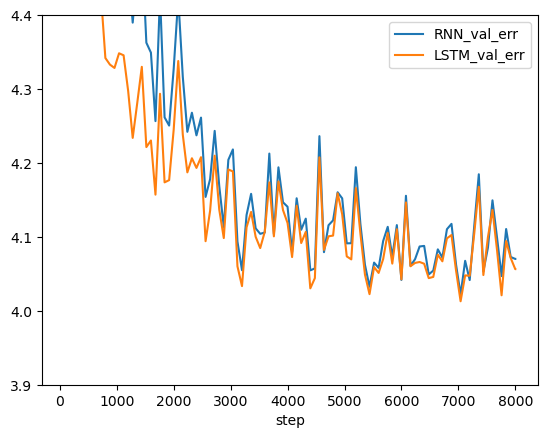

In [49]:
show_metrics(['RNN', 'LSTM'], 3.9, 4.4, False)

What this graph displays is that LSTM performs slightly better than RNN. It's errors are consistently below those of RNN and it converged there just a little bit faster.

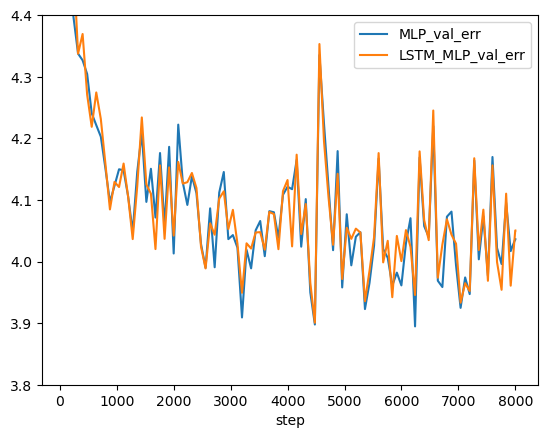

In [50]:
show_metrics(['MLP', 'LSTM_MLP'], 3.8, 4.4, False)

This graph shows that MLP has a slight edge on using LSTM with MLP, but not by much. The blue line is below the orange more frequently and only by a little bit.

When comparing the two graphs, RNN and LSTM might have greater values to begin with, but they appear to be less volatile. Despite the larger scale for the MLPs, it still is much more "jumpy" when compared to the RNNs which used Linears with slightly lower lows which signal greater accuracy, but also significantly higher highs. In sum, the MLP models converge much more quickly (in fewer steps), but don't gain as much as the other two models with increased steps and are more prone to volatility.

Additionally, it looks like all the models converged for an approximate error of 4.05.

# Application Test - Predictions

Here is where we'll play around with the models a bit to see if it can take a player with at least 3 seasons of experience and predict their next season's output. We will use a range of players spanning different situations.

- Duncan Keith's 2015-16 through 2017-18 seasons to predict his 2018-19 season to display aging curve impact on a 35+ player
- Evgeni Malkin's 2013-14 through 2015-16 seasons to predict his 2016-17 season to display the impact of a player having injury history
- Lars Eller's 2015-16 through 2017-18 seasons to predict his 2018-19 season to display how the models will project a player lower in a lineup
- Jack Hughes's 2021-22 through 2023-24 seasons to predict his 2024-25 season to display how the models will project a young player who is emerging as a star
- Jared McCann's 2021-22 through 2023-24 seasons to predict his 2024-25 season to display if the models will take shooting percentage outliers into account
- Rasmus Dahlin's 2021-22 through 2023-24 seasons to predict his 2024-25 season to display the models' effectiveness on a prime-aged star defender

## New Helpers

We will need new helpers in order to use the model to try and predict their performances.

First we will make a function that will retrieve a player's info from the dataset.

In [51]:
def get_player(df, name, season):
    data = df[(df['Name'] == name) & (df['SEASON_year'] == season)]

    if data.empty:
        raise ValueError(f'Player \'{name}\' not found for season end {season}')
    
    # if multiple entries, return first
    return data.iloc[0]

Next we need to have a function that takes the row and applies it to a selected model.

In [52]:
def predict(model, row):
    model.eval()

    # ensure on same device as model
    #
    # I used GPU
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device('cpu')

    # input tensor
    x = torch.tensor(
        row[inputs].values.astype(np.float32),
        device=device,
    ).unsqueeze(0)

    with torch.no_grad():
        prediction = model(x).squeeze(0)

    # actual values
    actual = torch.tensor(row[targets].values.astype(np.float32))

    # we need the prediction back on the CPU to use np/pd
    cpu_pred = prediction.cpu()

    result = pd.DataFrame(
        {
            'Actual': actual.numpy(),
            'Predicted': cpu_pred.numpy(),
        },
        index=targets,
    )

    return result

An additional function for simplifying running the prediction on all models.

In [53]:
def pred_all(models, row):
    results = {}

    for name, model in models.items():
        results[name] = predict(model, row)

    return results

A global definition of the models we use.

In [54]:
models = {
    'MLP': mlp,
    'RNN': rnn,
    'LSTM': lstm,
    'LSTM_MLP': lstm_mlp,
}

And a function to display the results of our prediction.

In [55]:
def display_results(results):
    first_name = next(iter(results))
    first_df = results[first_name]

    table = pd.DataFrame(index=first_df.index)
    table['Actual'] = first_df['Actual']

    for name, df in results.items():
        table[name] = df['Predicted']

    # the above will give us the per game totals predicted.

    # we want the actual predicted totals as well so it's easier to compare
    # with proper numbers
    per_gp_mask = table.index.str.endswith("_per_gp_next")
    per_gp_rows = table[per_gp_mask]

    gp_pred = table.loc['Games_Played_next']

    # this number is rounded because we can't have half a point
    # it affects error, but gives us a more realistic number
    totals = per_gp_rows.mul(gp_pred, axis=1).round(0)

    totals.index = totals.index.str.replace('_per_gp_next', '')

    table = pd.concat([table, totals])

    # error computation so we know how far off the model is

    error_percents = (table.div(table['Actual'], axis=0) * 100 - 100).abs()

    del error_percents['Actual']

    error_percents.columns = [col + '_err%' for col in error_percents.columns]
    table = pd.concat([table, error_percents], axis=1)

    return table

## Duncan Keith

This player was chosen to see if the model will apply an aging curve to him.

In [56]:
DK_stats = []

for i in range(2016, 2020):
    DK_stats.append(get_player(df, 'Duncan Keith', i))

DK_stats = pd.DataFrame(DK_stats)
DK_stats.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,SOG_per_gp,SEASON_year_next,Games_Played_next,Goals_next,Assists_next,Points_next,Shots_on_Goal_next,G_per_gp_next,A_per_gp_next,SOG_per_gp_next
6746,Duncan Keith,1983-07-16,2016,67,9.0,34.0,43.0,130.0,4.0,14.0,...,1.940299,2017.0,80.0,6.0,47.0,53.0,183.0,0.075000,0.587500,2.287500
6747,Duncan Keith,1983-07-16,2017,80,6.0,47.0,53.0,183.0,2.0,13.0,...,2.287500,2018.0,82.0,2.0,30.0,32.0,187.0,0.024390,0.365854,2.280488
6748,Duncan Keith,1983-07-16,2018,82,2.0,30.0,32.0,187.0,2.0,8.0,...,2.280488,2019.0,82.0,6.0,34.0,40.0,141.0,0.073171,0.414634,1.719512
6749,Duncan Keith,1983-07-16,2019,82,6.0,34.0,40.0,141.0,0.0,3.0,...,1.719512,2020.0,61.0,3.0,24.0,27.0,111.0,0.049180,0.393443,1.819672


Now we will actually use the DataFrame compatible with the model.

In [57]:
DK_stats = get_player(df_3yr, 'Duncan Keith', 2018)

DK_results = pred_all(models, DK_stats)
display(display_results(DK_results).style.format('{:.3f}'))

,Actual,MLP,RNN,LSTM,LSTM_MLP,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
G_per_gp_next,0.073,0.054,0.137,0.127,0.068,26.756,86.654,73.934,6.703
A_per_gp_next,0.415,0.326,0.373,0.485,0.363,21.259,10.110,16.977,12.516
SOG_per_gp_next,1.720,2.007,1.794,2.038,2.025,16.711,4.325,18.498,17.792
Games_Played_next,82.000,64.729,68.532,68.526,65.347,21.063,16.424,16.432,20.308
G,6.000,3.000,9.000,9.000,4.000,50.000,50.000,50.000,33.333
A,34.000,21.000,26.000,33.000,24.000,38.235,23.529,2.941,29.412
SOG,141.000,130.000,123.000,140.000,132.000,7.801,12.766,0.709,6.383


Below I will output his age for reference.

In [58]:
# output age for Keith
DK_stats['Age']

35

Age 35 in hockey tends to be the age where teams are cautious and predict age-based regression.

For the analysis and every one that follows, we'll stick to stats on a per game basis rather than the totals. Those are displayed more to give a less analytical reader something easier to understand. Because the totals are not only based on two predicted numbers but also rounded, the error percentages are more bloated with them in many cases or off relative to the error of the predicted numbers at the very least.

With the exception of LSTM's MLP version, the numbers for goals appear wildly off. However, the actual per game rate is below 0.1, so that means there will likely be a lot fluctuation with any discrepancy. The other per game rates are well within reasonable with all number except for MLP's assist prediction falling under 20%. The output for games played is less than desirable, but this could be taking aging into account which is what we want as the numbers predict a total around or below the samples.

## Evgeni Malkin

Malkin here represents a player with injury history who consistently failed to hit 70 games played in the 3 sample seasons. We will see if the model takes that into account.

In [59]:
EM_stats = []

for i in range(2014, 2018):
    EM_stats.append(get_player(df, 'Evgeni Malkin', i))

EM_stats = pd.DataFrame(EM_stats)
EM_stats.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,SOG_per_gp,SEASON_year_next,Games_Played_next,Goals_next,Assists_next,Points_next,Shots_on_Goal_next,G_per_gp_next,A_per_gp_next,SOG_per_gp_next
7292,Evgeni Malkin,1986-07-31,2014,60,23.0,49.0,72.0,191.0,7.0,23.0,...,3.183333,2015.0,69.0,28.0,42.0,70.0,212.0,0.405797,0.608696,3.072464
7293,Evgeni Malkin,1986-07-31,2015,69,28.0,42.0,70.0,212.0,9.0,17.0,...,3.072464,2016.0,57.0,27.0,31.0,58.0,162.0,0.473684,0.543860,2.842105
7294,Evgeni Malkin,1986-07-31,2016,57,27.0,31.0,58.0,162.0,11.0,16.0,...,2.842105,2017.0,62.0,33.0,39.0,72.0,191.0,0.532258,0.629032,3.080645
7295,Evgeni Malkin,1986-07-31,2017,62,33.0,39.0,72.0,191.0,11.0,12.0,...,3.080645,2018.0,78.0,42.0,56.0,98.0,239.0,0.538462,0.717949,3.064103


In [60]:
EM_stats = get_player(df_3yr, 'Evgeni Malkin', 2016)

EM_results = pred_all(models, EM_stats)
display(display_results(EM_results).style.format('{:.3f}'))

,Actual,MLP,RNN,LSTM,LSTM_MLP,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
G_per_gp_next,0.532,0.321,0.373,0.340,0.293,39.705,29.929,36.140,44.919
A_per_gp_next,0.629,0.556,0.552,0.563,0.592,11.555,12.250,10.445,5.809
SOG_per_gp_next,3.081,2.713,2.527,2.587,2.656,11.919,17.967,16.019,13.793
Games_Played_next,62.000,62.387,64.175,63.359,66.001,0.624,3.508,2.192,6.454
G,33.000,20.000,24.000,22.000,19.000,39.394,27.273,33.333,42.424
A,39.000,35.000,35.000,36.000,39.000,10.256,10.256,7.692,0.000
SOG,191.000,169.000,162.000,164.000,175.000,11.518,15.183,14.136,8.377


As far as the predictions go, assist and shot rates are all reasonably within range of predictions. However, goals are far off. Looking at the goal rates of past seasons...

In [61]:
EM_stats = []

for i in range(2014, 2018):
    EM_stats.append(get_player(df, 'Evgeni Malkin', i))

EM_stats = pd.DataFrame(EM_stats)
EM_stats['G_per_gp']

7292    0.383333
7293    0.405797
7294    0.473684
7295    0.532258
Name: G_per_gp, dtype: float64

The models all predict a down trend that puts his total below anything he has produced the past three seasons. Not the most desirable or logical result for a prediction model.

In [62]:
EM_stats[['SEASON_year', 'Age']]

,SEASON_year,Age
7292,2014,28
7293,2015,29
7294,2016,30
7295,2017,31


Given his ages, a sharp downturn shouldn't be strongly predicted either based on current knowledge. Again, less than desirable.

What we were checking though was the models' ability to take injury and games played into account. As far as that goes, it was very accurate. Most numbers fell within 5%, all within 10%.

## Lars Eller

This is an example of a depth player who wouldn't get the same level statistical production that more prominent players might. However, he was consistently used lower in the lineup as a regular.

In [63]:
LE_stats = []

for i in range(2016, 2020):
    LE_stats.append(get_player(df, 'Lars Eller', i))

LE_stats = pd.DataFrame(LE_stats)
LE_stats.head()

,Name,Date_of_birth,SEASON_year,Games_Played,Goals,Assists,Points,Shots_on_Goal,PowerPlay_Goals,PowerPlay_Assists,...,SOG_per_gp,SEASON_year_next,Games_Played_next,Goals_next,Assists_next,Points_next,Shots_on_Goal_next,G_per_gp_next,A_per_gp_next,SOG_per_gp_next
12376,Lars Eller,1989-05-08,2016,79,13.0,13.0,26.0,149.0,1.0,0.0,...,1.886076,2017.0,81.0,12.0,13.0,25.0,115.0,0.148148,0.160494,1.419753
12377,Lars Eller,1989-05-08,2017,81,12.0,13.0,25.0,115.0,0.0,1.0,...,1.419753,2018.0,81.0,18.0,20.0,38.0,161.0,0.222222,0.246914,1.987654
12378,Lars Eller,1989-05-08,2018,81,18.0,20.0,38.0,161.0,3.0,3.0,...,1.987654,2019.0,81.0,13.0,23.0,36.0,163.0,0.160494,0.283951,2.012346
12379,Lars Eller,1989-05-08,2019,81,13.0,23.0,36.0,163.0,0.0,3.0,...,2.012346,2020.0,69.0,16.0,23.0,39.0,151.0,0.231884,0.333333,2.188406


In [64]:
LE_stats = get_player(df_3yr, 'Lars Eller', 2018)

LE_results = pred_all(models, LE_stats)
display(display_results(LE_results).style.format('{:.3f}'))

,Actual,MLP,RNN,LSTM,LSTM_MLP,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
G_per_gp_next,0.160,0.190,0.273,0.201,0.130,18.541,69.861,25.029,19.048
A_per_gp_next,0.284,0.282,0.340,0.343,0.311,0.649,19.603,20.787,9.597
SOG_per_gp_next,2.012,1.901,1.815,1.788,1.878,5.549,9.787,11.152,6.695
Games_Played_next,81.000,68.761,70.322,70.487,68.719,15.110,13.182,12.980,15.161
G,13.000,13.000,19.000,14.000,9.000,0.000,46.154,7.692,30.769
A,23.000,19.000,24.000,24.000,21.000,17.391,4.348,4.348,8.696
SOG,163.000,131.000,128.000,126.000,129.000,19.632,21.472,22.699,20.859


Once again, shot and assist rates are within reasonable ranges while goal rates are bloated. MLP especially seemed to do well with the rates for this particular player when compared to the RNN models.

In [65]:
LE_stats = []

for i in range(2016, 2020):
    LE_stats.append(get_player(df, 'Lars Eller', i))

LE_stats = pd.DataFrame(LE_stats)
LE_stats[['SEASON_year', 'G_per_gp', 'A_per_gp', 'SOG_per_gp', 'Age']]

,SEASON_year,G_per_gp,A_per_gp,SOG_per_gp,Age
12376,2016,0.164557,0.164557,1.886076,27
12377,2017,0.148148,0.160494,1.419753,28
12378,2018,0.222222,0.246914,1.987654,29
12379,2019,0.160494,0.283951,2.012346,30


These numbers tell us something about why the model predicted what it did though. They saw an uptick progressively in stats and given age, it's not entirely unreasonable to predict that to continue. The models were wrong though and that's the result we care about. Most concerning is that despite upward trends elsewhere, the models predicted a downward trend in games played despite this player's history. 82 is the max number of games played in a season and he was consistently close to that number. Predicting him at 70 or less is far from a good outcome.

**The following players are not in the dataset. This means we will have to input their data manually. What it does show is that the model is applicable to players outside the original data.**

## Jack Hughes

This player was chosen as an example of an emerging star player over his sample seasons. We want to see if the models can predict an uptick in his stats based on age and trends. Additionally, he does have injury history so that could be an element as well.

In [66]:
JH_stats = pd.Series({
    'G_per_gp_prev2': 11/56,
    'A_per_gp_prev2': 20/56,
    'P_per_gp_prev2': 31/56,
    'SOG_per_gp_prev2': 142/56,
    'Games_played_prev2': 56,
    'Shooting_Percentage_prev2': (11/142) * 100,

    'G_per_gp_prev': 26/49,
    'A_per_gp_prev': 30/49,
    'P_per_gp_prev': 56/49,
    'SOG_per_gp_prev': 165/49,
    'Games_played_prev': 49,
    'Shooting_Percentage_prev': (26/165) * 100,

    'G_per_gp': 43/78,
    'A_per_gp': 56/78,
    'P_per_gp': 99/78,
    'SOG_per_gp': 336/78,
    'Shooting_Percentage': (43/336) * 100,
    'Games_Played': 78,

    'Position': 0,
    'Age': 22,
    'Experience': 4,
    'Height': 180,
    'Weight': 79.4,
    'Body_mass_index': 79.4 / (1.80**2),

    'G_per_gp_next': 27/62,
    'A_per_gp_next': 47/62,
    'P_per_gp_next': 74/62,
    'SOG_per_gp_next': 274/62,
    'Games_Played_next': 62,
})


In [67]:
JH_results = pred_all(models, JH_stats)
display(display_results(JH_results).style.format('{:.3f}'))

,Actual,MLP,RNN,LSTM,LSTM_MLP,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
G_per_gp_next,0.435,0.405,0.469,0.476,0.456,7.008,7.684,9.372,4.734
A_per_gp_next,0.758,0.752,0.659,0.725,0.743,0.827,13.079,4.324,2.023
SOG_per_gp_next,4.419,3.892,3.767,3.789,3.990,11.934,14.755,14.272,9.725
Games_Played_next,62.000,67.784,71.375,73.062,70.383,9.330,15.122,17.842,13.521
G,27.000,27.000,33.000,35.000,32.000,0.000,22.222,29.630,18.519
A,47.000,51.000,47.000,53.000,52.000,8.511,0.000,12.766,10.638
SOG,274.000,264.000,269.000,277.000,281.000,3.650,1.825,1.095,2.555


The numbers here appear far more accurate. That is most likely because the per game rates are higher which means a greater denominator for error percentage calculation. Honestly, star players make the model look better, but the better performance is real too. As far as per game rates, let's compare them to the most recent input season to compare.

In [68]:
JH_stats[['G_per_gp', 'A_per_gp', 'SOG_per_gp']]

G_per_gp      0.551282
A_per_gp      0.717949
SOG_per_gp    4.307692
dtype: float64

This shows that the models predicted a regression his past season. While not wrong when it comes to goals, that was not the case for the other per game stats. Less than ideal for predicting a young player improving. What it did do was predict less games than a full season which turned out to be an overestimation. This is our first large overestimation for that stat.

## Jared McCann

This player was chosen because he had a season with a standout shooting percentage, which is generally an indicator of an outlier season. We want to see if the model takes this into account and predicts accordingly.

In [69]:
JM_stats = pd.Series({
    'G_per_gp_prev2': 27/74,
    'A_per_gp_prev2': 23/74,
    'P_per_gp_prev2': 50/74,
    'SOG_per_gp_prev2': 199/74,
    'Games_played_prev2': 74,
    'Shooting_Percentage_prev2': (27/199) * 100,

    'G_per_gp_prev': 40/79,
    'A_per_gp_prev': 30/79,
    'P_per_gp_prev': 70/79,
    'SOG_per_gp_prev': 210/79,
    'Games_played_prev': 79,
    'Shooting_Percentage_prev': (40/210) * 100,

    'G_per_gp': 29/80,
    'A_per_gp': 33/80,
    'P_per_gp': 62/80,
    'SOG_per_gp': 216/80,
    'Shooting_Percentage': (29/216) * 100,
    'Games_Played': 80,

    'Position': 0,
    'Age': 27,
    'Experience': 8,
    'Height': 185,
    'Weight': 84,
    'Body_mass_index': 84 / (1.85**2),

    'G_per_gp_next': 22/82,
    'A_per_gp_next': 39/82,
    'P_per_gp_next': 61/82,
    'SOG_per_gp_next': 202/82,
    'Games_Played_next': 82,
})

These shooting percentages turn out to be...

In [70]:
[27/199 * 100, 40/210 * 100, 29/216 * 100, 22/202 * 100]

[13.5678391959799, 19.047619047619047, 13.425925925925927, 10.891089108910892]

Now we'll do the usual and process the results.

In [71]:
JM_results = pred_all(models, JM_stats)
display(display_results(JM_results).style.format('{:.3f}'))

,Actual,MLP,RNN,LSTM,LSTM_MLP,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
G_per_gp_next,0.268,0.356,0.417,0.376,0.328,32.762,55.544,40.100,22.111
A_per_gp_next,0.476,0.493,0.517,0.602,0.562,3.707,8.713,26.499,18.104
SOG_per_gp_next,2.463,2.535,2.486,2.578,2.633,2.910,0.908,4.633,6.901
Games_Played_next,82.000,68.652,71.201,71.747,68.609,16.278,13.169,12.503,16.331
G,22.000,24.000,30.000,27.000,22.000,9.091,36.364,22.727,0.000
A,39.000,34.000,37.000,43.000,39.000,12.821,5.128,10.256,0.000
SOG,202.000,174.000,177.000,185.000,181.000,13.861,12.376,8.416,10.396


This doesn't look great on the surface. The assist and shot predictions seem quite accurate, especially for MLP and RNN, but the goals are all wildly out of range. However, looking at his above shooting percentages tells us that his "next" season that we're predictiing was a down season in terms of shooting percentage. So let's look at what the models predicted his shooting percentage to be.

In [72]:
pd.Series({
    name: 100 * df.loc['G_per_gp_next', 'Predicted'] / df.loc['SOG_per_gp_next', 'Predicted']
    for name, df in JM_results.items()
})

MLP         14.050375
RNN         16.788029
LSTM        14.582742
LSTM_MLP    12.440687
dtype: float64

All of the models predicted a regression from his high season that is more in line with his usual. Had he shot anywhere near his usual shooting percentage, then the prediction numbers likely would not look so bad. Below we'll calculate his goal total if he had shot 13%, still below each of his previous totals.

In [73]:
(202* 0.13) / 82

0.3202439024390244

0.320 is much more in line with our model's predictions. Granted, down years happen in sports and aren't always avoidable. However, as a test to see if the models can take an outlying shooting percentage as an input and take it into account, this seems to pass. An issue though is that they again predicted fewer games played.

## Rasmus Dahlin

This player is an example of a prime aged star player who is also a defenceman, providing a largely different example from the others above.

In [74]:
RD_stats = pd.Series({
    'G_per_gp_prev2': 13/80,
    'A_per_gp_prev2': 40/80,
    'P_per_gp_prev2': 53/80,
    'SOG_per_gp_prev2': 170/80,
    'Games_played_prev2': 80,
    'Shooting_Percentage_prev2': (13/170) * 100,

    'G_per_gp_prev': 15/78,
    'A_per_gp_prev': 58/78,
    'P_per_gp_prev': 73/78,
    'SOG_per_gp_prev': 204/78,
    'Games_played_prev': 78,
    'Shooting_Percentage_prev': (15/204) * 100,

    'G_per_gp': 20/81,
    'A_per_gp': 39/81,
    'P_per_gp': 59/81,
    'SOG_per_gp': 235/81,
    'Shooting_Percentage': (20/235) * 100,
    'Games_Played': 81,

    'Position': 1,
    'Age': 24,
    'Experience': 6,
    'Height': 190,
    'Weight': 92,
    'Body_mass_index': 92 / (1.90**2),

    'G_per_gp_next': 17/73,
    'A_per_gp_next': 51/73,
    'P_per_gp_next': 68/73,
    'SOG_per_gp_next': 200/73,
    'Games_Played_next': 73,
})


In [75]:
RD_results = pred_all(models, RD_stats)
display(display_results(RD_results).style.format('{:.3f}'))

,Actual,MLP,RNN,LSTM,LSTM_MLP,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
G_per_gp_next,0.233,0.276,0.276,0.263,0.280,18.318,18.516,12.888,20.395
A_per_gp_next,0.699,0.572,0.599,0.637,0.611,18.081,14.251,8.751,12.576
SOG_per_gp_next,2.740,2.768,2.730,2.779,3.005,1.047,0.353,1.427,9.684
Games_Played_next,73.000,72.585,76.331,76.405,72.555,0.568,4.563,4.664,0.609
G,17.000,20.000,21.000,20.000,20.000,17.647,23.529,17.647,17.647
A,51.000,42.000,46.000,49.000,44.000,17.647,9.804,3.922,13.725
SOG,200.000,201.000,208.000,212.000,218.000,0.500,4.000,6.000,9.000


For an additional case that was thrown in to check off a different category, this is a pleasant surprise. A case can be made that these are the most accurate results yet. Only one number is over 20% and it's only by a little bit. The LSTM model did particularily well on all accounts. The games played total feels a little bit lucky since it predicted a lower total despite his history, but it's also our highest total yet.

## Overall

Goals had the highest error percentage of all the stats, but those are known to be varying stats. Assists and shots on goal rates were quite accurate, consistently falling below 20% and often 15% error. Higher actual numbers assist this as that means the denominator is larger and therefore the error percentage is lower. Predicted games played was an issue. Despite having the highest percentage of accuracy, this number was made to look better because it was the highest number of any other predicted by a lot and we already discussed why that leads to better percentages. Only one player had his predicted games played over 75. It appears being prime aged was a factor. The MLP models in particular did a poor job here. This might be a cause for that "jumpiness" mentioned earlier when looking at the graphs. RNN and LSTM are able to read the seasons sequentially where MLP reads it as one big stat line, so it can read the trends a bit better. MLP inside the LSTM likely diluted that in its version.

Below is code to calculate error for each model per the individual players.

In [76]:
player_results = {
    "Duncan Keith": DK_results,
    "Evgeni Malkin": EM_results,
    "Lars Eller": LE_results,
    "Jack Hughes": JH_results,
    "Jared McCann": JM_results,
    "Rasmus Dahlin": RD_results,
}

result_rows = [
    "G_per_gp_next",
    "A_per_gp_next",
    "SOG_per_gp_next",
    "Games_Played_next",
]

In [77]:
player_avg_err = {}

# we need to run the results through our display function
# since that's where the error is determined
for player, res in player_results.items():
    table = display_results(res)
    err_cols = [col for col in table.columns if col.endswith("_err%")]
    player_avg_err[player] = table.loc[result_rows, err_cols].mean()

player_avg_err = pd.DataFrame(player_avg_err).T

display(player_avg_err.style.format("{:.3f}"))

,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
Duncan Keith,21.447,29.378,31.460,14.330
Evgeni Malkin,15.951,15.913,16.199,17.744
Lars Eller,9.962,28.108,17.487,12.625
Jack Hughes,7.275,12.660,11.452,7.501
Jared McCann,13.914,19.584,20.934,15.862
Rasmus Dahlin,9.504,9.421,6.932,10.816


And below is code that averages the error over each player.

In [78]:
model_avg_err = player_avg_err.mean(axis=0)
display(model_avg_err.to_frame("avg_err_%").T.style.format("{:.3f}"))

,MLP_err%,RNN_err%,LSTM_err%,LSTM_MLP_err%
avg_err_%,13.009,19.177,17.411,13.146


So, over our samples, MLP performed the best across the players with an error of just over 13%. The MLP version of LSTM wasn't far behind while they both outperformed RNN and LSTM by a fair bit despite these two models appearing to perform better in relation to games played. This is likely because the dataset is relatively small and the sequence we're feeding is only 3 seasons, not long enough for RNN and LSTM to truly take advantage. Additionally, because we initially treated the data and set it up for MLP by flattening three seasons, we lose the features per season like age and experience that would have helped RNN and LSTM. A larger dataset and less treated data along with a full history may have helped those two models. Additionally, we removed some other indicators like time on ice per game that may have helped them. This was because the data was inconsistent and not recorded for every player in the dataset. In the end, MLP performed best in this format.